In [58]:
import pandas as pd
from pandas_datareader import data as pdr
import yahoo_fin as yf
import numpy as np
import datetime as dt
import yfinance as yf
import plotly.express as px
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  
%matplotlib inline

# Create our portfolio of equities
tickers = ["AAPL", "FB", "C", "DIS"]


data: pd.DataFrame = yf.download(tickers, start="2018-01-01", end=dt.date.today())[
    "Close"
]
data.reset_index(inplace=True)
if len(data) > 0:
    data.to_csv("../../data/stock_prices.csv", index=False)

[**********************75%***********            ]  3 of 4 completed

/var/folders/76/vq20631j4bx6nq6nf0v8gb300000gn/T/ipykernel_94622/1915611936.py:13: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



[*********************100%***********************]  4 of 4 completed

1 Failed download:
- FB: No timezone found, symbol may be delisted


In [59]:
data = pd.read_csv("../../data/stock_prices.csv", parse_dates=["Date"])
# From the closing prices, calculate periodic returns
data = data.drop(columns="Date")
data.head()

,AAPL,C,DIS,FB
0,43.064999,74.360001,111.800003,NaN
1,43.057499,74.589996,112.279999,NaN
2,43.257500,75.510002,112.230003,NaN
3,43.750000,75.410004,111.620003,NaN
4,43.587502,74.529999,110.019997,NaN


In [60]:
returns = data.pct_change()[1:].dropna(axis='columns')
returns.head()

,AAPL,C,DIS
1,-0.000174,0.003093,0.004293
2,0.004645,0.012334,-0.000445
3,0.011385,-0.001324,-0.005435
4,-0.003714,-0.011670,-0.014334
5,-0.000115,0.010466,-0.000727


Text(0, 0.5, 'daily returns')

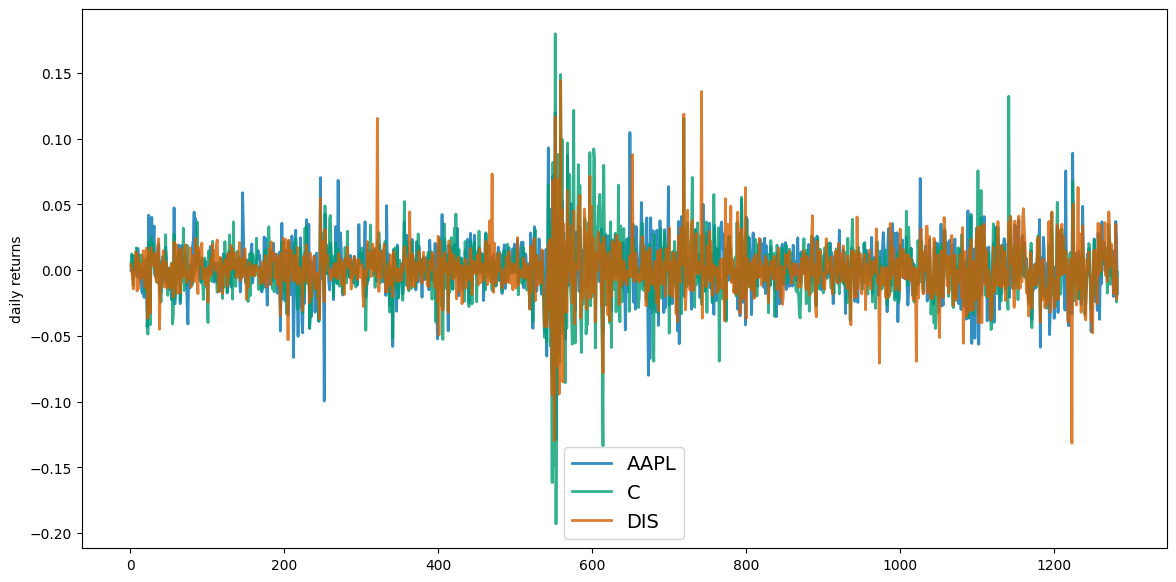

In [61]:
plt.figure(figsize=(14, 7))
for i in returns.columns.values:
    plt.plot(returns.index, returns[i], lw=2, alpha=0.8,label=i)
plt.legend(loc='lower center', fontsize=14)
plt.ylabel('daily returns')


In [62]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights: int, mean_returns: pd.Series, cov_matrix: pd.DataFrame):
    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) * 252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [63]:
def generate_random_portfolios(num_portfolios: int, mean_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate: float):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((len(mean_returns),num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(len(mean_returns))
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array


In [64]:
# returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
num_portfolios = 10000
# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates
risk_free_rate = 0.018


In [72]:
def display_simulated_portfolios(returns: pd.DataFrame, mean_returns: pd.Series, cov_matrix: pd.DataFrame, num_portfolios: int, risk_free_rate: float):
    nr_of_assets = len(mean_returns)
    results, weights = generate_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    df = pd.DataFrame(weights, columns=returns.columns)
    df["portfolio_std_dev"], df["portfolio_return"],df["sharpe_ratio"] = results[0],results[1],results[2]

    portfolio_weights = df.iloc[:, :nr_of_assets]
    fig = px.scatter(df, x=df["portfolio_std_dev"], y=df["portfolio_return"],hover_data=portfolio_weights, color="sharpe_ratio", color_continuous_scale='ylorbr', size=np.ones(results.shape[1]) * 10, opacity=0.3)

    pf_high_sharpe = df.iloc[df['sharpe_ratio'].idxmax()]
    pf_hgh_return = df.iloc[df['portfolio_return'].idxmax()]
    pf_low_variance = df.iloc[df['portfolio_std_dev'].idxmax()]
    fig.add_scatter(x=[pf_high_sharpe["portfolio_std_dev"]], y=[pf_high_sharpe["portfolio_return"]], mode='markers', marker=dict(size=45, color='red'), name='Max Sharpe ratio')
    fig.add_scatter(x=[pf_hgh_return["portfolio_std_dev"]], y=[pf_hgh_return["portfolio_return"]], mode='markers', marker=dict(size=45, color='red'), name='Max Returns')
    fig.add_scatter(x=[pf_low_variance["portfolio_std_dev"]], y=[pf_low_variance["portfolio_return"]], mode='markers', marker=dict(size=45, color='red'), name='Min Variance')
    fig.update_layout(title='Simulated portfolios illustrating efficient frontier', xaxis_title='annualized volatility', yaxis_title='annualized returns')
    fig.show()


display_simulated_portfolios(returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [ ]:
data = pd.read_csv("../../data/stock_prices.csv", parse_dates=["Date"])
data = data.drop(columns="Date")
returns = data.pct_change()[1:].dropna(axis="columns")

mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
num_portfolios = 10
# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates
risk_free_rate = 0.018

fig = display_simulated_portfolios(
    returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate
)

In [ ]:
type(fig)

In [ ]:
fig.show()